## Loading dataset from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)

100%|██████████| 1.02G/1.02G [00:15<00:00, 71.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


# Spliting dataset into Train, Test and Validation

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
output_dir = 'split_dataset'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create directories for split dataset
def create_dir_structure():
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)

# Split dataset
def split_dataset():
    create_dir_structure()

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        # Get all image file paths in the current class folder
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Split data into train (70%), temp (30%)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)

        # Further split temp into validation (10%) and test (20%)
        val_images, test_images = train_test_split(temp_images, test_size=2/3, random_state=42)

        # Move images to respective directories
        for image in train_images:
            dest_dir = os.path.join(train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in val_images:
            dest_dir = os.path.join(val_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in test_images:
            dest_dir = os.path.join(test_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

# Run the script
if __name__ == '__main__':
    split_dataset()
    print("Dataset successfully split into train, validation, and test sets!")


Dataset successfully split into train, validation, and test sets!


In [ ]:
import glob
from pathlib import Path

train_path = 'split_dataset/train/'
test_path  = 'split_dataset/test/'
val_path = 'split_dataset/val/'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('val images')
for filepath in glob.glob(val_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

# files = glob.glob(test_path + '/*')
# print(f"{len(files)} \t {Path(test_path).name}")

train images
1115 	 hispa
1234 	 normal
235 	 bacterial_panicle_blight
335 	 bacterial_leaf_blight
1009 	 dead_heart
761 	 tungro
1216 	 blast
266 	 bacterial_leaf_streak
434 	 downy_mildew
675 	 brown_spot
test images
320 	 hispa
354 	 normal
68 	 bacterial_panicle_blight
96 	 bacterial_leaf_blight
289 	 dead_heart
218 	 tungro
348 	 blast
76 	 bacterial_leaf_streak
124 	 downy_mildew
194 	 brown_spot
val images
159 	 hispa
176 	 normal
34 	 bacterial_panicle_blight
48 	 bacterial_leaf_blight
144 	 dead_heart
109 	 tungro
174 	 blast
38 	 bacterial_leaf_streak
62 	 downy_mildew
96 	 brown_spot


# Model Initialization and Training

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
# import tensorflow_addons as tfa
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
SEED = 123
EPOCHS = 50
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [ ]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(val_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 5827 images belonging to 10 classes.
Found 202 images belonging to 10 classes.
Found 2087 images belonging to 10 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
5827 202 2087


In [ ]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    # tf.keras.utils.plot_model(back_bone, to_file='xception.png',show_shapes=False, show_layer_names=False)
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,827,442 (79.45 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='xception.weights.best.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

# Training Model

In [ ]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.3807 - loss: 1.8136
Epoch 1: val_loss improved from inf to 0.83393, saving model to xception.weights.best.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 210s 881ms/step - accuracy: 0.3816 - loss: 1.8113 - val_accuracy: 0.7129 - val_loss: 0.8339 - learning_rate: 1.0000e-04
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7933 - loss: 0.6496
Epoch 2: val_loss improved from 0.83393 to 0.51101, saving model to xception.weights.best.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 121s 637ms/step - accuracy: 0.7934 - loss: 0.6493 - val_accuracy: 0.8366 - val_loss: 0.5110 - learning_rate: 1.0000e-04
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8841 - loss: 0.3741
Epoch 3: val_loss improved from 0.51101 to 0.36452, saving model to xception.weights.best.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 123s 657ms/step - accuracy: 0.8842 - loss: 0.3740 - val_accuracy: 0.9010 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 4/50
183/1

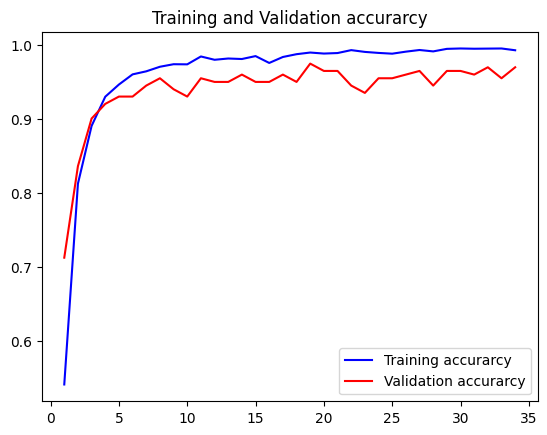

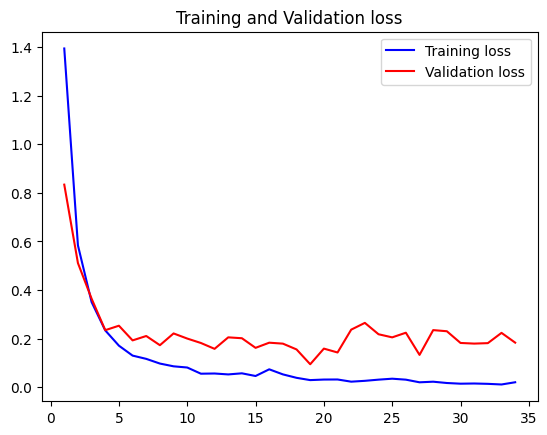

CPU times: user 493 ms, sys: 227 ms, total: 720 ms
Wall time: 505 ms


In [ ]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Model Testing

In [ ]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
320 	 hispa
354 	 normal
68 	 bacterial_panicle_blight
96 	 bacterial_leaf_blight
289 	 dead_heart
218 	 tungro
348 	 blast
76 	 bacterial_leaf_streak
124 	 downy_mildew
194 	 brown_spot
Found 2087 images belonging to 10 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('xception.weights.best.keras')
pred = model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 96.12%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.95506   0.88542   0.91892        96
   bacterial_leaf_streak    0.92500   0.97368   0.94872        76
bacterial_panicle_blight    1.00000   0.89706   0.94574        68
                   blast    0.96812   0.95977   0.96392       348
              brown_spot    0.96842   0.94845   0.95833       194
              dead_heart    0.99313   1.00000   0.99655       289
            downy_mildew    0.93220   0.88710   0.90909       124
                   hispa    0.95975   0.96875   0.96423       320
                  normal    0.95628   0.98870   0.97222       354
                  tungro    0.93304   0.95872   0.94570       218

                accuracy                        0.96119      2087
               macro avg    0.95910   0.94676   0.95234      2087
            weighted avg    0.96139   0.96119   0.96100      2087



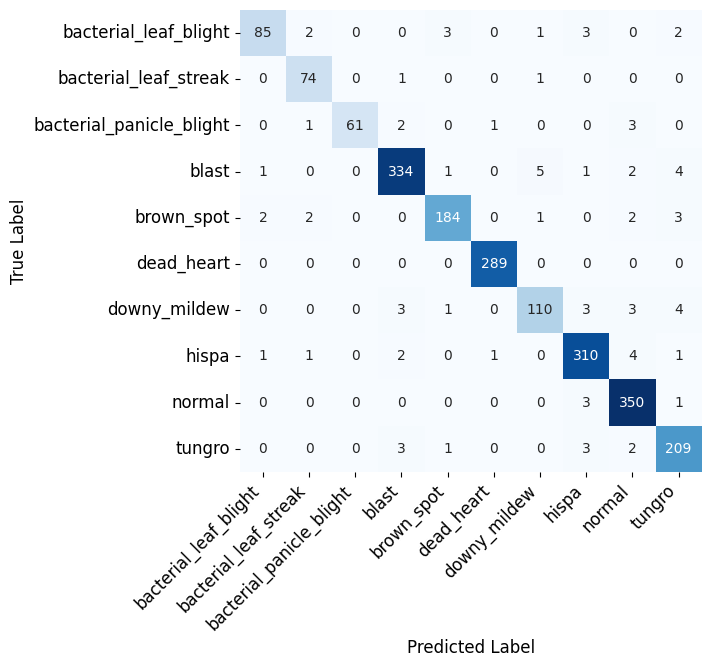

[[ 85   2   0   0   3   0   1   3   0   2]
 [  0  74   0   1   0   0   1   0   0   0]
 [  0   1  61   2   0   1   0   0   3   0]
 [  1   0   0 334   1   0   5   1   2   4]
 [  2   2   0   0 184   0   1   0   2   3]
 [  0   0   0   0   0 289   0   0   0   0]
 [  0   0   0   3   1   0 110   3   3   4]
 [  1   1   0   2   0   1   0 310   4   1]
 [  0   0   0   0   0   0   0   3 350   1]
 [  0   0   0   3   1   0   0   3   2 209]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

# Evaluate upon val dataset

In [ ]:
loss, acc = model.evaluate(valid_datagen, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9604 - loss: 0.1563     


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


0.9603960514068604 0.15627604722976685


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
normal,366
blast,345
hispa,323
dead_heart,291
tungro,224
brown_spot,190
downy_mildew,118
bacterial_leaf_blight,89
bacterial_leaf_streak,80
bacterial_panicle_blight,61


In [ ]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100133.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100268.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100330.jpg,brown_spot
3,bacterial_leaf_blight/100382.jpg,brown_spot
4,bacterial_leaf_blight/100447.jpg,bacterial_leaf_blight
